# Clustering by user-problem matrix

In [1]:
from scipy.sparse import csr_matrix
import numpy as np
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
with open('handle_cid_pid_keys.txt') as f:
    hcp = [c.strip().split(',') for c in f.readlines()]

In [3]:
handles = [x[0] for x in hcp]

problems = [x[1] + "_" + x[2] for x in hcp]

## Hash handles and problems to rows and columns

In [4]:
hh = {}
hp = {}

row = 0
for h in handles:
    if h not in hh:
        hh[h] = row
        row += 1
col = 0
for p in problems:
    if p not in hp:
        hp[p] = col
        col += 1

In [5]:
row_idx = [hh[h] for h in handles]
col_idx = [hp[p] for p in problems]

In [6]:
# sanity check
print len(row_idx)
print len(col_idx)

7526161
7526161


## Create sparse matrix in CSR format

In [75]:
# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
ones = np.ones(len(row_idx))
csr = csr_matrix((ones, (row_idx, col_idx)))

In [76]:
csr.shape

(56696, 9973)

In [8]:
svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)

In [9]:
svd.fit(csr) 

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=10,
       random_state=42, tol=0.0)

In [10]:
print svd.explained_variance_ratio_ 
print svd.explained_variance_ratio_.sum()

[ 0.10925832  0.04649858  0.03612382  0.02594963  0.01584698]
0.233677316953


In [11]:
csr_svd = svd.transform(csr)

In [12]:
csr_svd.shape

(56696, 5)

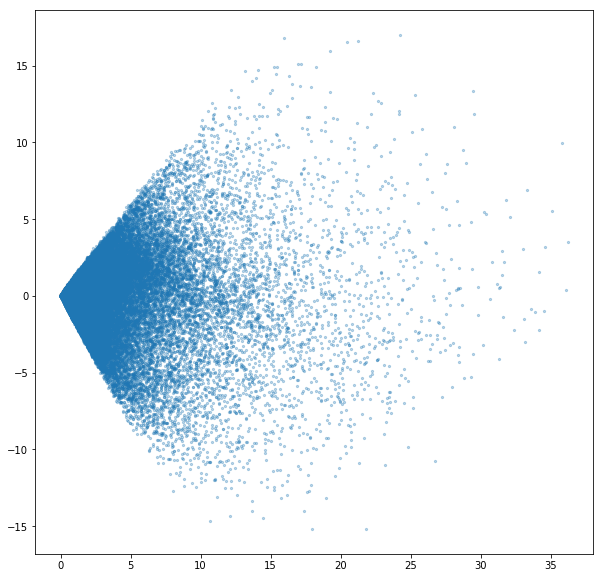

In [13]:
plt.scatter(csr_svd[:, 0], csr_svd[:, 1], s=5, alpha=.3)

###  TSNE dies with large data, sub sample

In [35]:
idx = np.random.choice(len(csr_svd), size=10000)
csr_svd_small = csr_svd[idx]

In [30]:
tsne = TSNE()

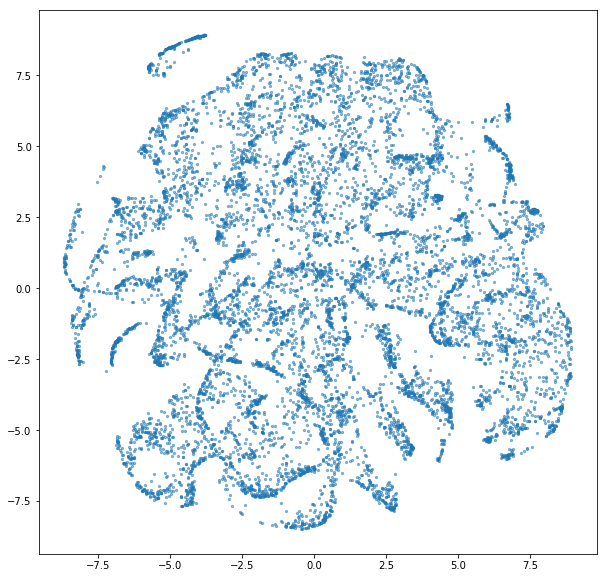

In [36]:
transformed = tsne.fit_transform(csr_svd_small)

plt.scatter(transformed[:, 0], transformed[:,1], s=5, alpha=.5)

# Train/val/test

In [107]:
# reconstruct y column
columns = ['' for i in range(max(hp.values())+1)]
for p in hp:
    columns[ hp[p] ] = p

# reconstruct row labels
rows = ['' for i in range(max(hh.values())+1)]
for h in hh:
    rows[ hh[h] ] = h

In [81]:
# create the ratings vector
ratings = np.zeros(max(hh.values())+1)
for k, v in df_rating.groupby('handle'):
    h = v.handle.values[0]
    if h in hh:
        ratings[ hh[h] ] = v.iloc[-1]['newrating']

In [119]:
with open('set_train.txt') as f:
    settrain = set([t.strip() for t in f.readlines()])
with open('set_test.txt') as f:
    settest = set([t.strip() for t in f.readlines()])
with open('set_val.txt') as f:
    setval = set([t.strip() for t in f.readlines()])

In [122]:
ixtrain = [i for i in range(len(rows)) if rows[i] in settrain]
ixtest = [i for i in range(len(rows)) if rows[i] in settest]
ixval = [i for i in range(len(rows)) if rows[i] in setval]

In [128]:
ytrain = ratings[ixtrain]
print len(ixtrain), ytrain.shape
ytest = ratings[ixtest]
print len(ixtest), ytest.shape
yval = ratings[ixval]
print len(ixval), yval.shape

25137 (25137,)
10629 (10629,)
8181 (8181,)


# Random forest regressor

In [47]:
import pandas as pd
df_rating = pd.read_csv('user_ratings_smoothed.csv')

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rf = RandomForestRegressor()

In [84]:
ntest = 1000
csr_small = csr[0:ntest]
y_small = ratings[0:ntest]

In [129]:
model = rf.fit(csr[ixtrain], ytrain)

In [131]:
print rf.score(csr[ixtrain], ytrain)
print rf.score(csr[ixtest], ytest)
print rf.score(csr[ixval], yval)

0.930647182408
0.707332806907
0.800376415074


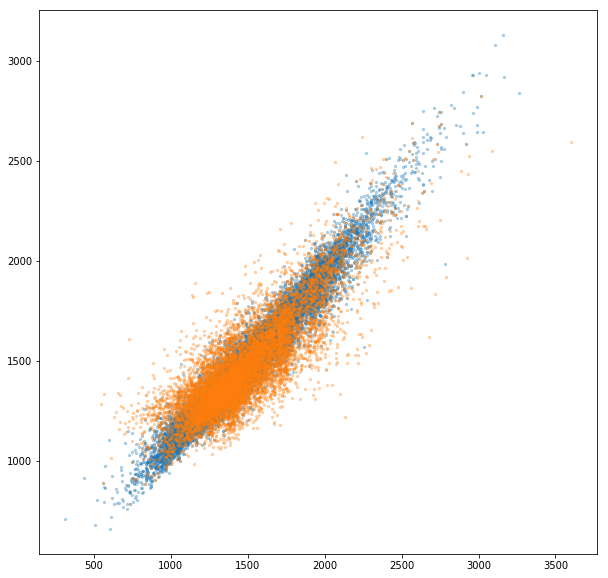

In [132]:
ypred = rf.predict(csr[ixtrain])
plt.scatter(ytrain, ypred, alpha=.3, s=5)
ypred = rf.predict(csr[ixtest])
plt.scatter(ytest, ypred, alpha=.3, s=5)

In [133]:
imp = pd.Series(rf.feature_importances_)
imp.index = columns

In [135]:
impsorted = imp.sort_values(ascending=False)

In [145]:
problem_rating = pd.read_csv("problem_ratings.csv")
problem_rating['contestid'] = problem_rating.contestid.apply(str)
problem_rating['contestid'] = problem_rating.contestid.apply(lambda x: x + "_")
problem_rating.index = problem_rating.contestid.str.cat(problem_rating.problemid)

In [150]:
imprates = problem_rating.loc[imp.index, 'problemrating']

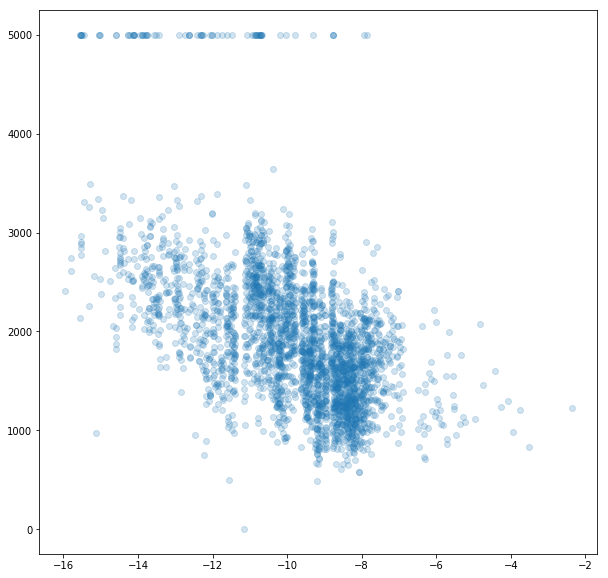

In [165]:
thresh = 0.0000001
plt.scatter(np.log(impsorted[impsorted > thresh]), imprates[impsorted > thresh], alpha=.2)